## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [79]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [80]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [81]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

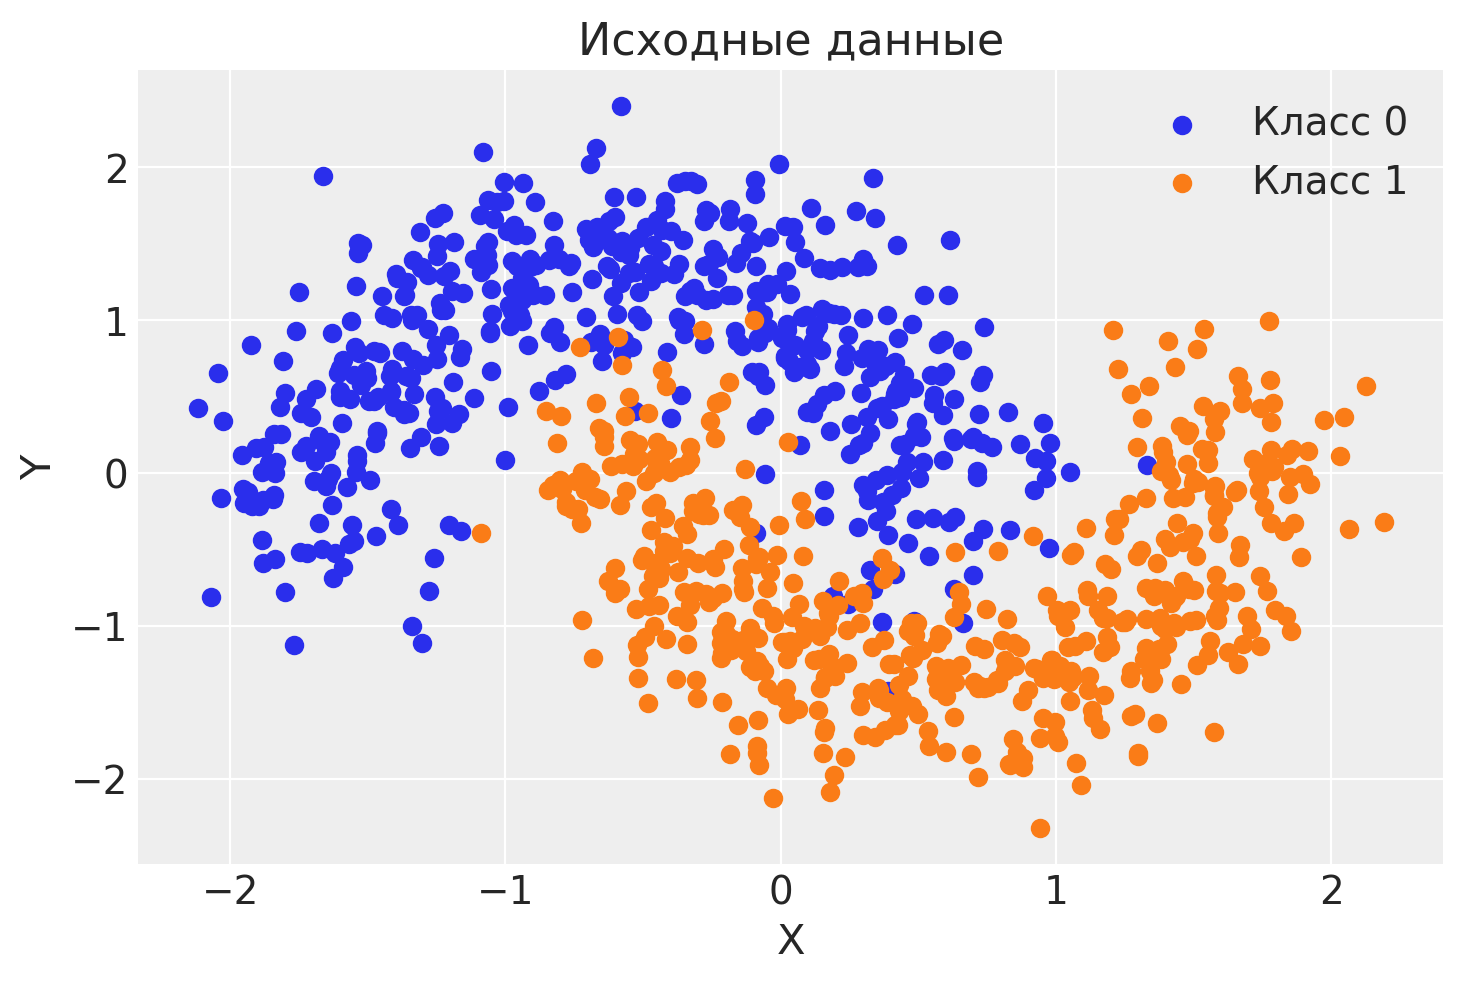

In [82]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Класс 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Класс 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Исходные данные");

In [83]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)


        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, testval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, testval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, testval=init_out, dims="hidden_layer_2")

        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [84]:
pm.set_tt_rng(42)

In [85]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(method=inference, n=50000)

Finished [100%]: Average Loss = 119.9


Wall time: 20.8 s


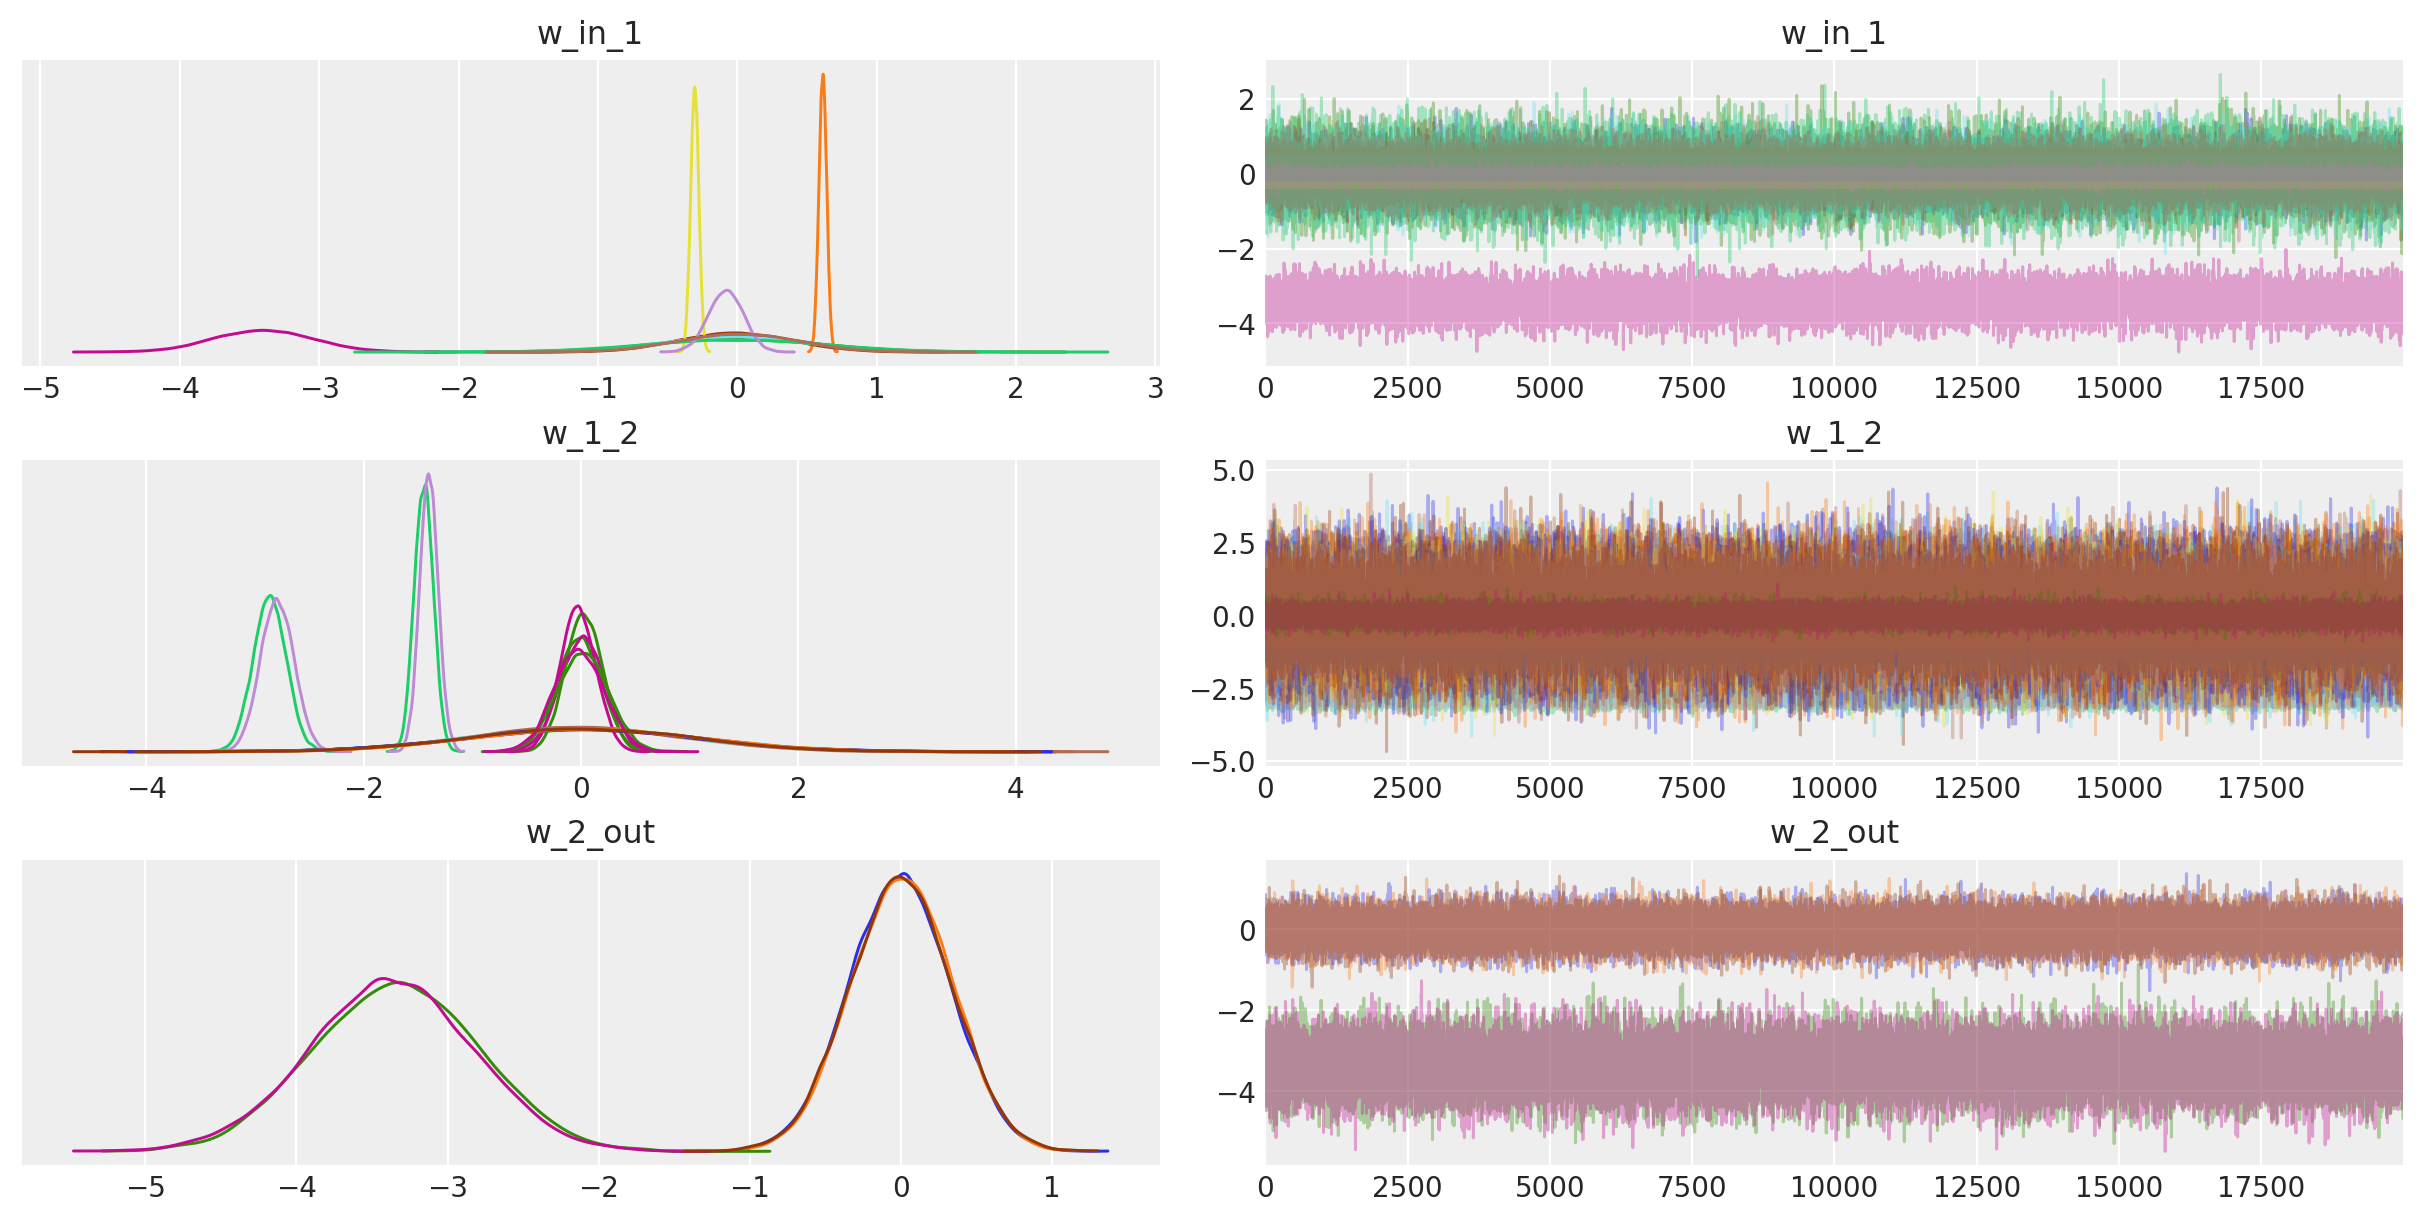

In [86]:
trace = approx.sample(20000)
trace = az.from_pymc3(trace, model=neural_network)
az.plot_trace(trace);

No handles with labels found to put in legend.


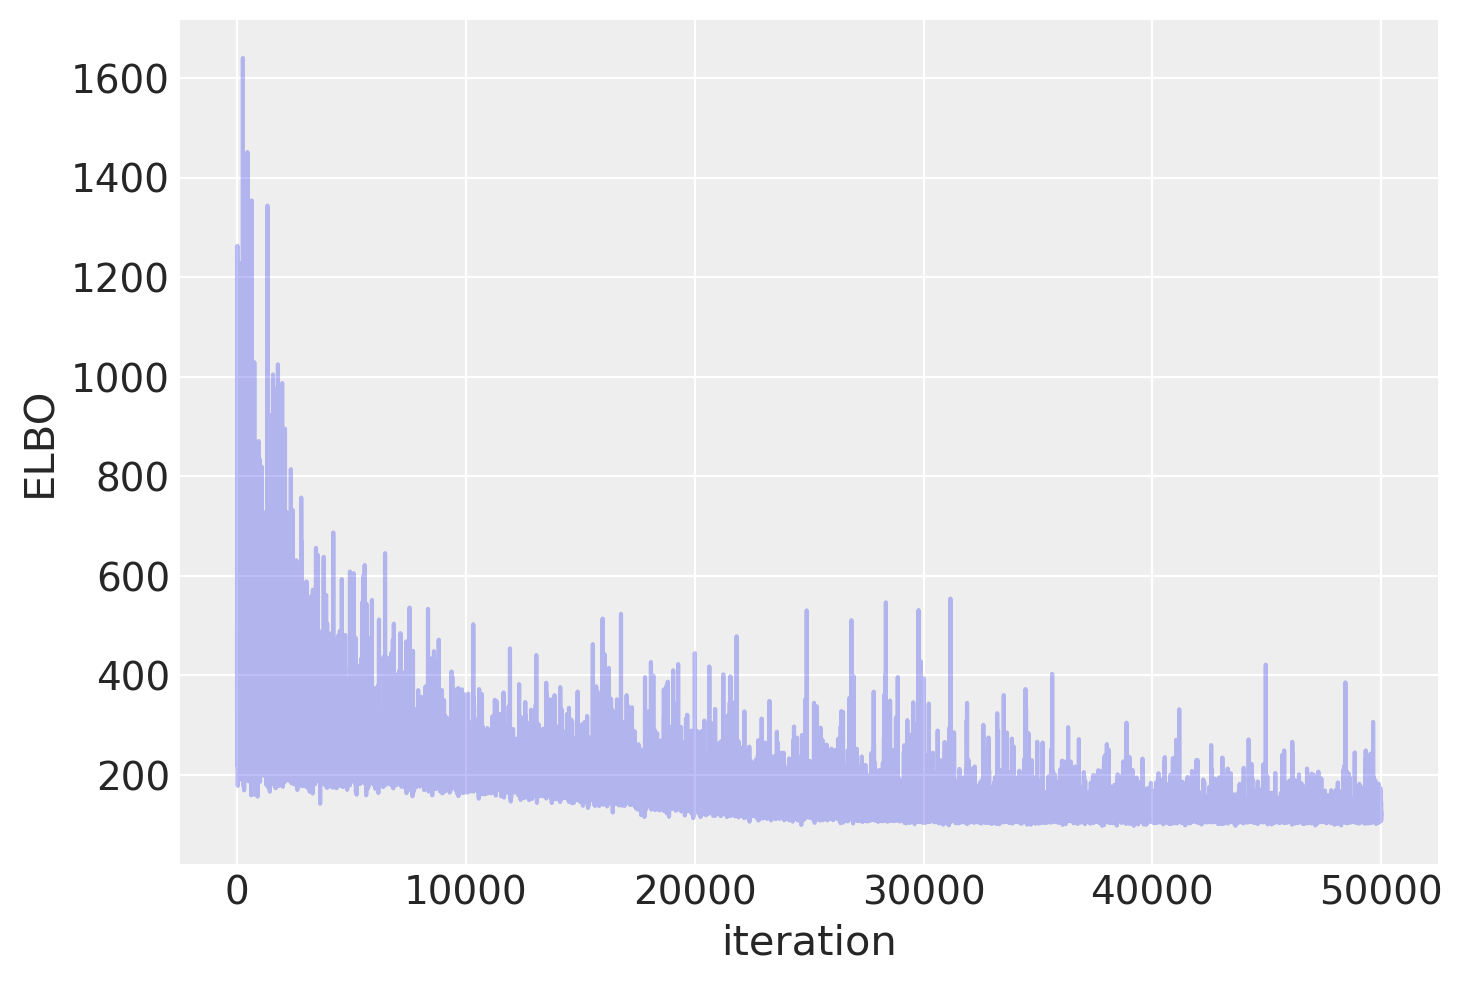

In [87]:
plt.plot(approx.hist, alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [88]:
neural_network.out.distribution.p

sigmoid.0

In [89]:
x = T.matrix("X")
n = T.iscalar("n")
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba)

In [90]:
%%timeit 
sample_proba(X_test, 500).mean(0) > 0.5

72.9 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

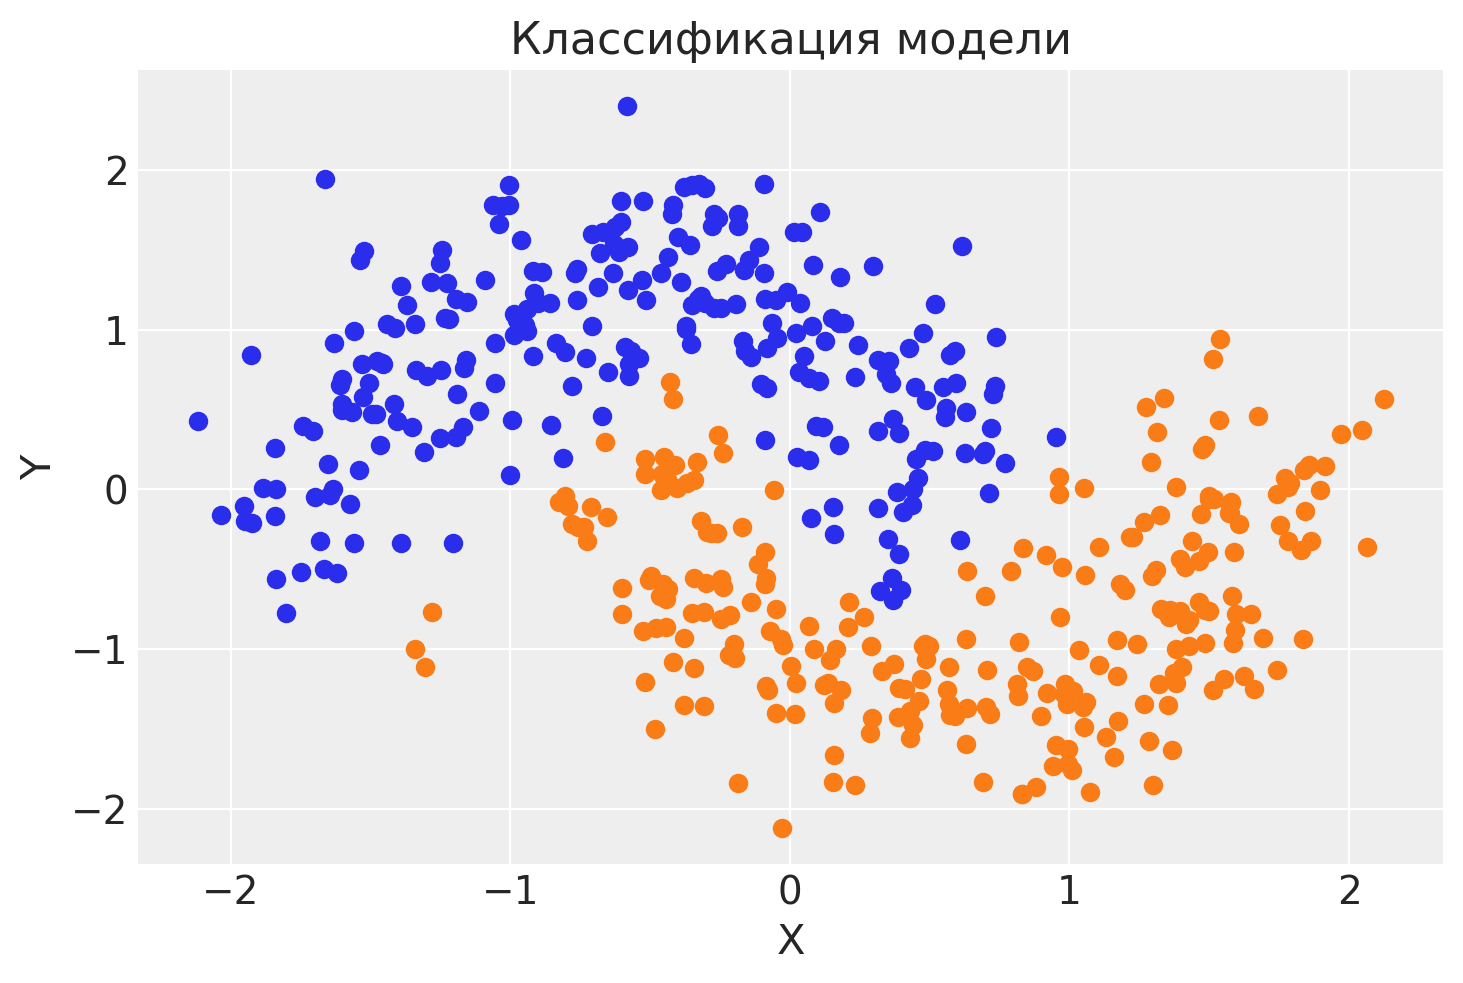

In [92]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Классификация модели", xlabel="X", ylabel="Y");

In [93]:
print("Accuracy = {:.2f}%".format((Y_test == pred).mean() * 100))

Accuracy = 95.20%


In [94]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [22]:
ppc = sample_proba(grid_2d, 500)

### Probability surface

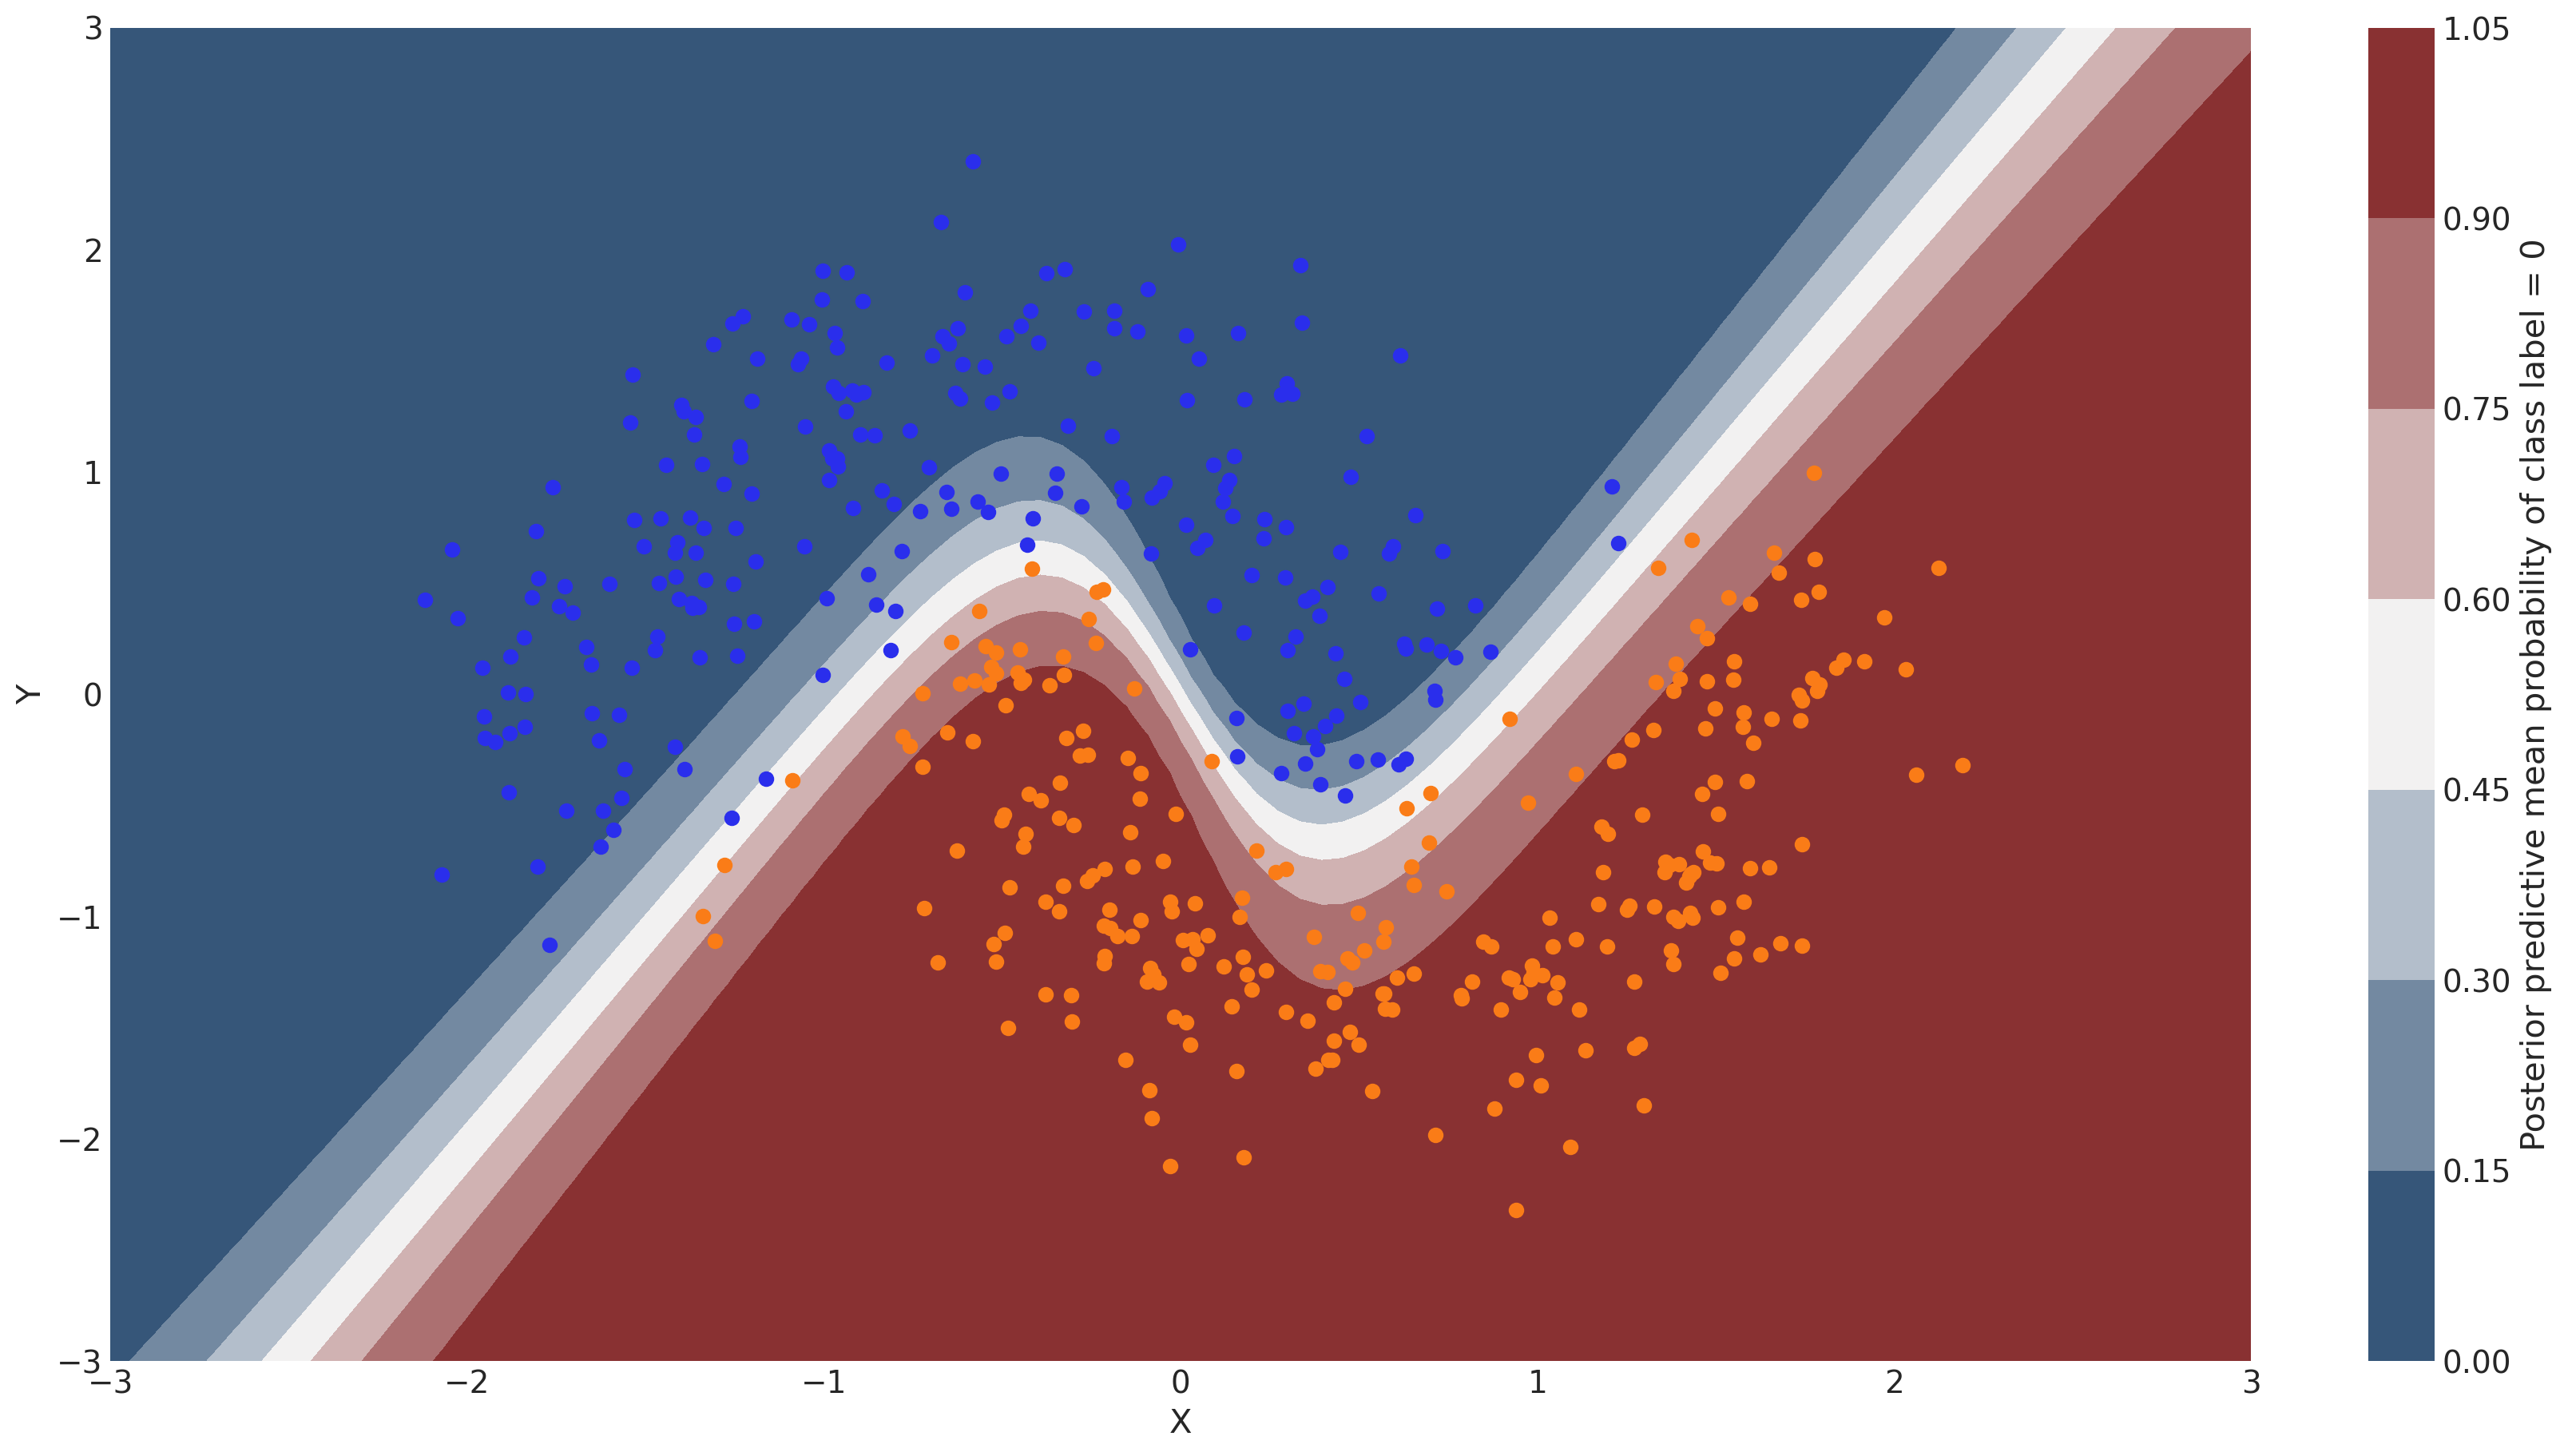

In [23]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");

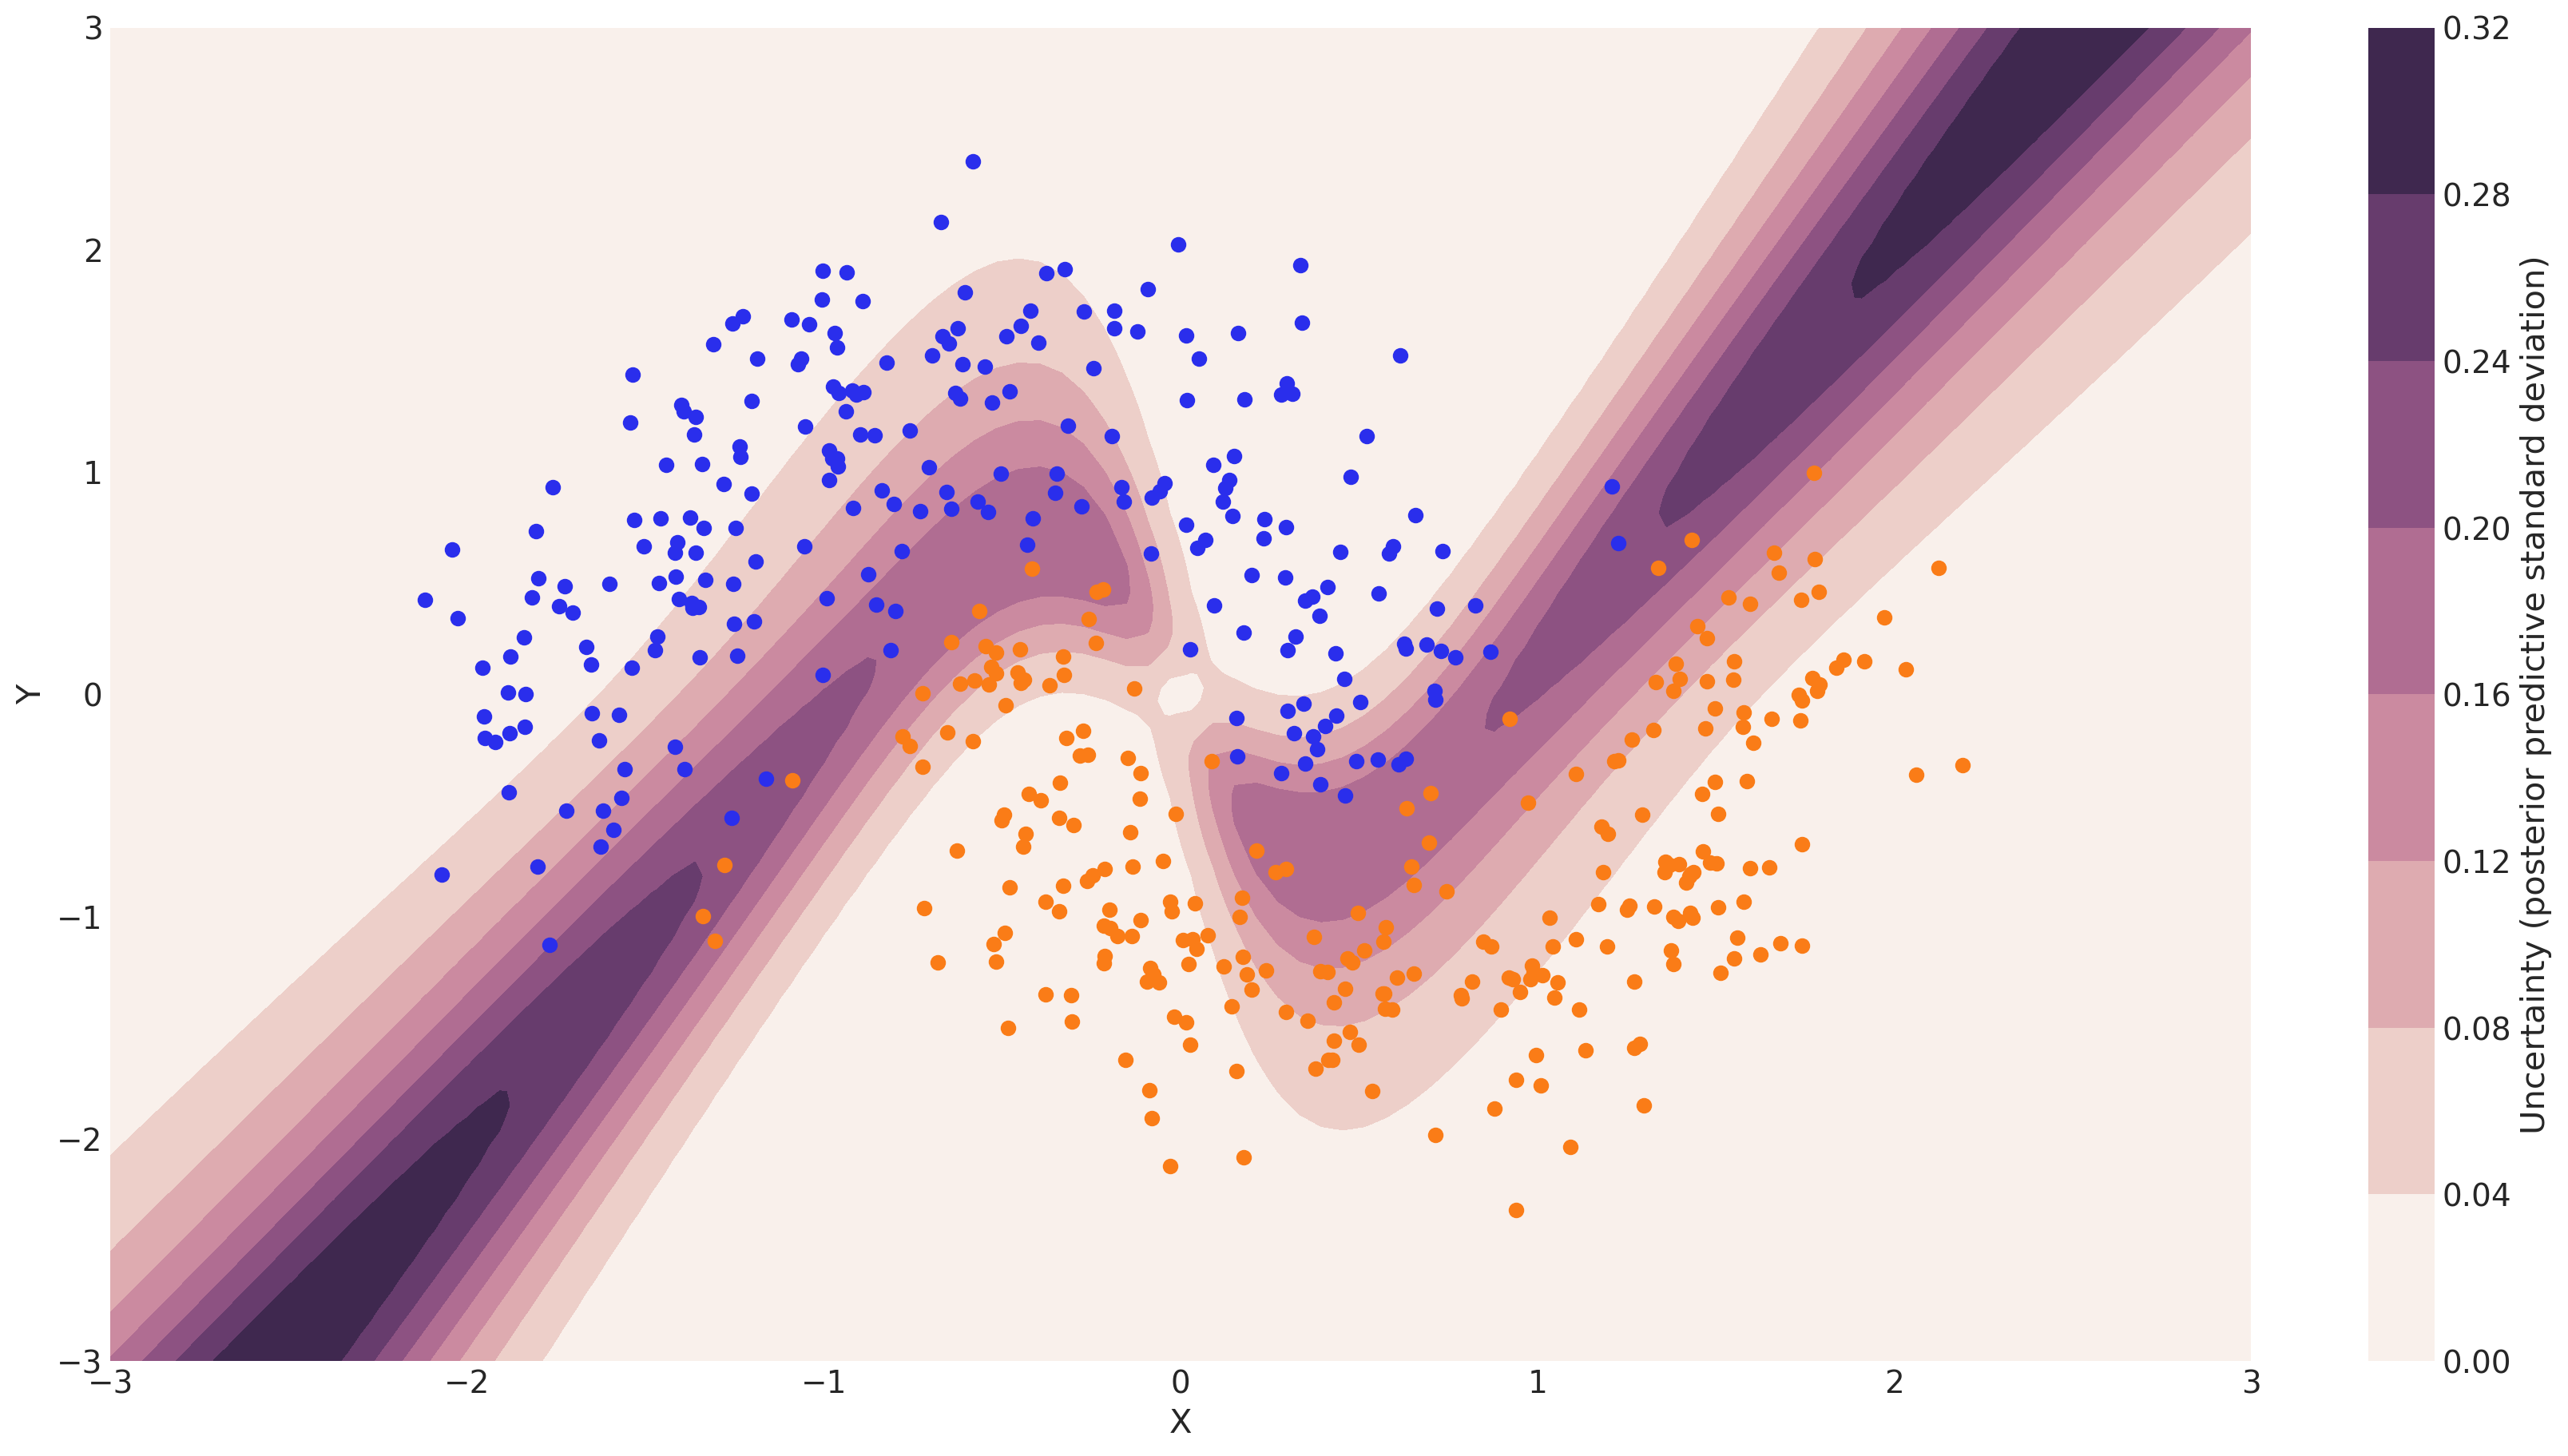

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

In [25]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

C:\Users\mik16\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\mik16\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 137.98


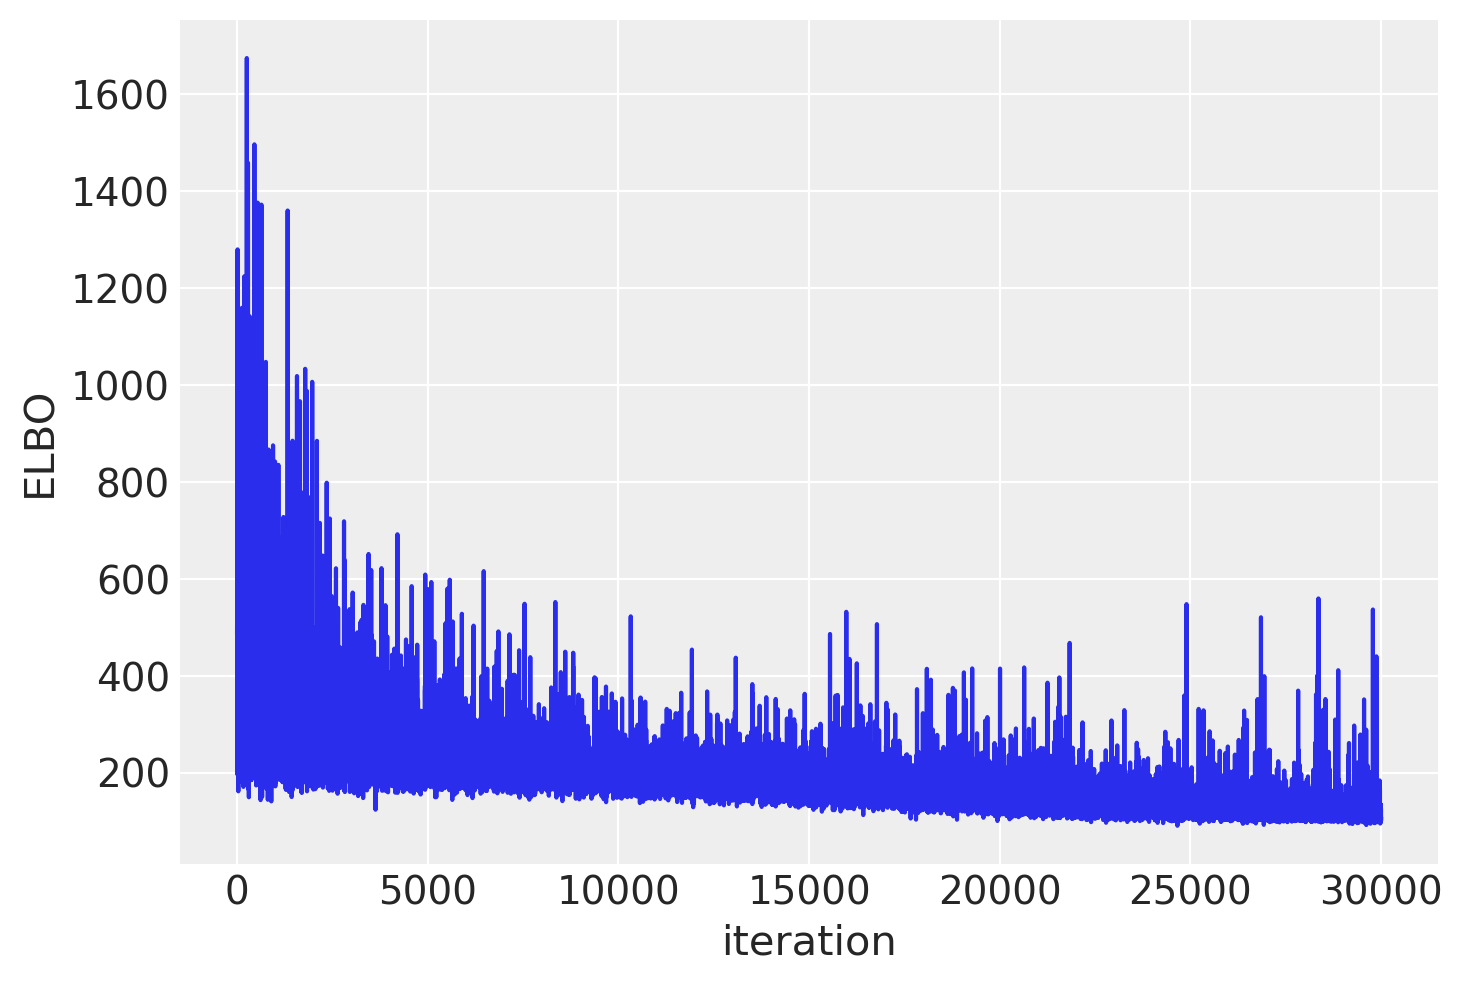

In [38]:
plt.plot(inference.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

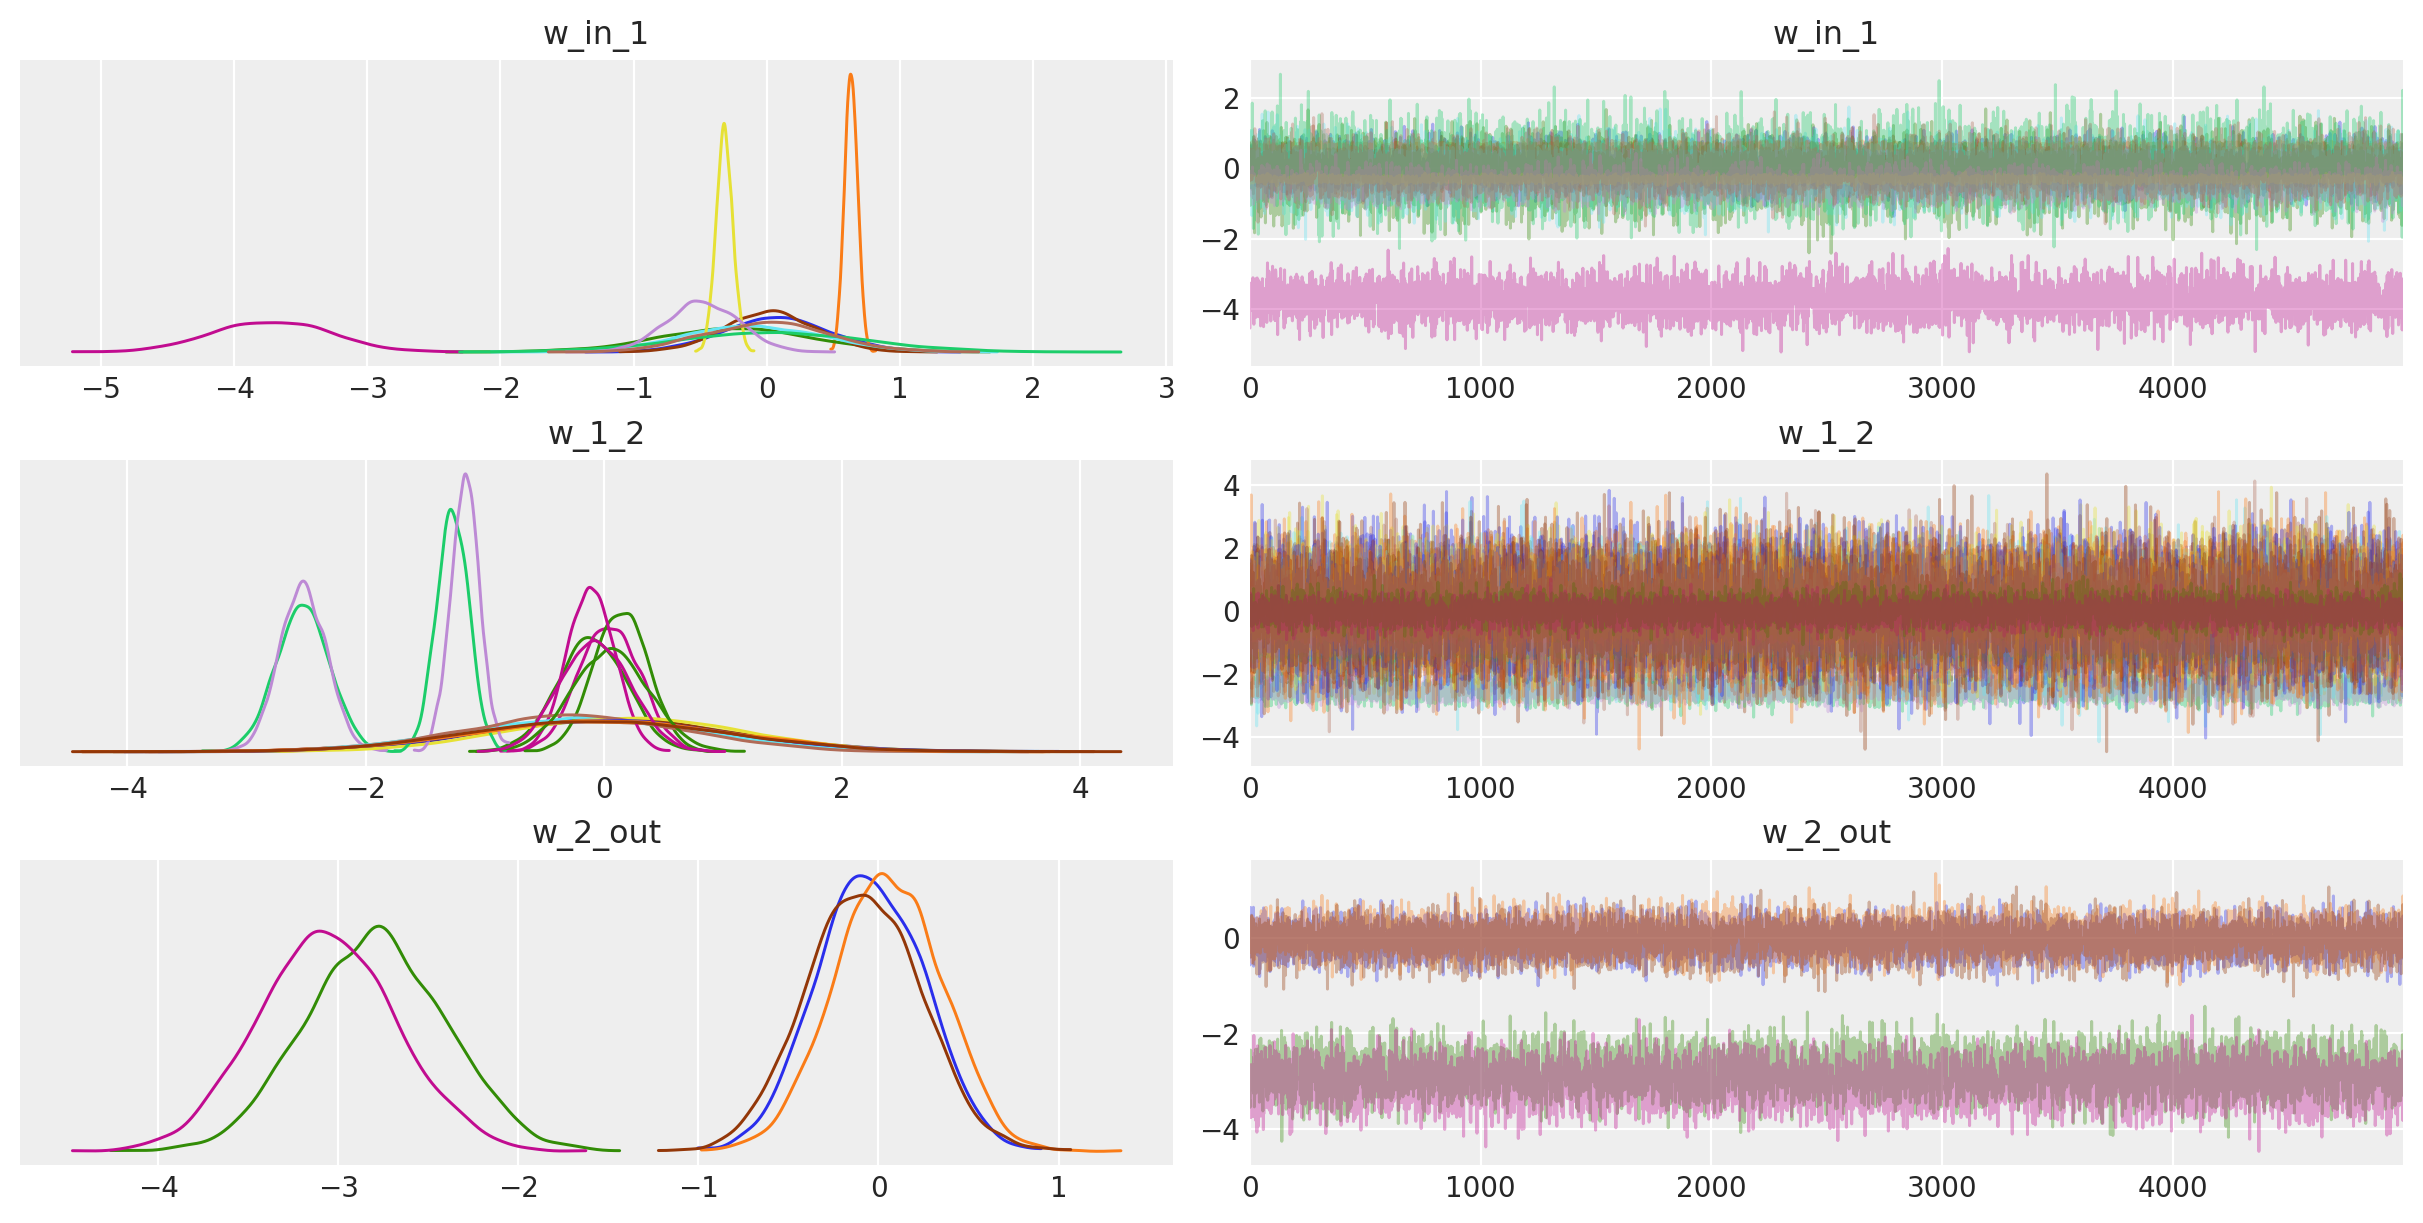

In [39]:
az.plot_trace(trace);